In [ ]:
import matplotlib.pyplot as plt # plotting library
import matplotlib.gridspec as gridspec # organizing plots in a grid
import numpy as np # numeric array manipulation
import pandas as pd # dataframe structure

from scipy.integrate import odeint # function to obtain trajectories from ODEs
from scipy.optimize import root
from scipy.optimize._numdiff import approx_derivative
from functools import partial


import ipywidgets as widgets # Widgets for parameter exploration
from IPython.display import display

## Example XX. 2D genetic oscillator

The following code integrates the 2-component oscillator discussed in the paper. The limit cycle attracts trajectories from different initial conditions, resulting in systained oscillations. Tuning the parameter one can observe how the limit cycle attractor appears and disappears, resulting in a stable steady-state fixed point of gene expression:

In [3]:
from IPython.display import IFrame

#iframe = '<img src="https://drive.google.com/open?id=12bljTFSTE4aM2zyPDNSJ4eDNvbB_Hcgo&usp=drive_fs">'

iframe = 'https://drive.google.com/file/d/12bljTFSTE4aM2zyPDNSJ4eDNvbB_Hcgo/preview'
IFrame(iframe,800,300)

interactive(children=(FloatSlider(value=24.0, description='alpha_x', max=34.0, min=15.0), FloatSlider(value=0.…

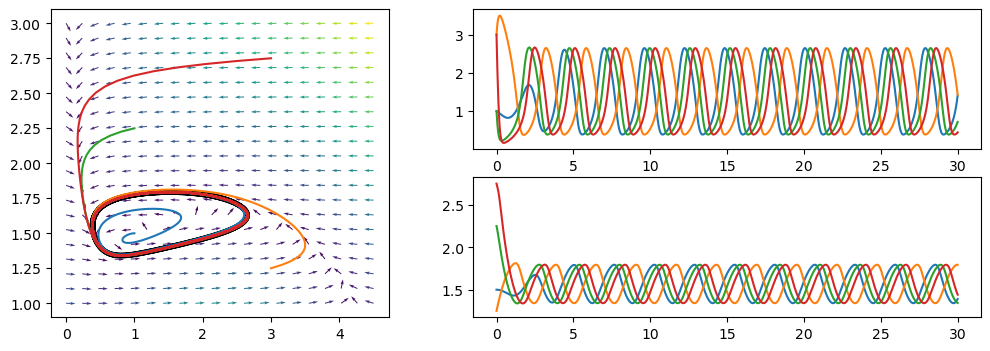

In [6]:
def oscillator_ODE(xy, t, params): 
  """
  Evaluates the r.h.s of the ODEs describing an oscillatory network
  """
  x, y = xy
  globals().update(params) ## unpacks parameters so they can be accessed by their name
  flow = [
         alpha_x*(1 + a*x**2)/(1+x**2+b*y**2) - lambda_x*x ,
         alpha_y*(1+ a*x**2)/(1+x**2) - lambda_y*y
         ]
  return flow



def find_ss(params):
  """
  Find the steady state of the oscillator system
  """
  globals().update(params) ## unpacks parameters so they can be accessed by their name
  ss = root(
          oscillator_ODE,
          [2,2],
          args = (0, params))
  
  jacobian = approx_derivative(partial(oscillator_ODE,t=0,params=params),ss.x) # jacobian of the ODE at the steady state
  stability = np.sign(jacobian[0,0]+jacobian[1,1]) # sign of the trace of the determinant
  return ss.x,stability 

def compute_flow(params):
  """
  Calculates the flow of the dynamical systems in a grid and returns the values in a dataframe
  """
  # construct a grid of values to compute the rates of change at
  X, Y = np.mgrid[0:4.5:20j, 1:3:20j]

  # compute the rates of change for the toggle switch at each position in the grid
  flow = oscillator_ODE([X, Y], 0, params)

  # pack into a dataframe for easy plotting
  data = pd.DataFrame(
      {'X': X.flatten(),
       'Y':  Y.flatten(),
       'U': np.array(flow[0]).flatten(),
       'V': np.array(flow[1]).flatten()
    })
  # compute the absolute speed of the system at each position
  data['speed'] = np.sqrt(data['U']**2 + data['V']**2)
  data['U_direction'] = data['U']/data['speed']
  data['V_direction'] = data['V']/data['speed']
  
  return data


def plot_oscillations(**params):
  """
    Plot visualizing the oscillations
  """  
  # Generating grid and layout for the subplots
  fig = plt.figure(constrained_layout=False,figsize=(12,4))
  plot_grid = gridspec.GridSpec(2, 2,width_ratios=[2,3],figure = fig)
  axis_left = fig.add_subplot(plot_grid[:, 0])
  axis_topright = fig.add_subplot(plot_grid[0,1])
  axis_bottomright = fig.add_subplot(plot_grid[1,1])
  
  # plotting flow at different points x,y  
  flow = compute_flow(params)
  axis_left.quiver(flow['X'], flow['Y'], flow['U_direction'], flow['V_direction'], flow['speed'])
  
  # plotting trajectories and limit orbit
  initial_conditions = [[1.0,1.5], [3,1.25],[1,2.25],[3,2.75]]
  num_time_steps = 1000 # time steps to integrate and find cycle
  t = np.linspace(0, 30, num_time_steps)
  for initial_condition in initial_conditions:
    sol = odeint(oscillator_ODE, initial_condition, t, args=(params,))
    axis_left.plot(sol[:,0],sol[:,1])
    axis_topright.plot(t,sol[:,0])
    axis_bottomright.plot(t,sol[:,1])
  
  # plotting steady state  
  axis_left.plot(sol[-200:,0],sol[-200:,1],'k-',lw=4,zorder = 0)
  ss,stability = find_ss(params)
  color_stability = {0:'black',1:'white'}
  axis_left.scatter(ss[0], ss[1], c=color_stability[stability], s=20)
  
  # setting axes labels and limits
  axis_topright.set_ylabel('X')
  axis_bottomright.set_ylabel('Y')
  axis_bottomright.set_xlabel('time')
  axis_left.set_xlim([0,4.5])
  axis_left.set_xlabel('X')
  axis_left.set_ylim([1,3])
  axis_left.set_ylabel('Y')
  
  
  plt.show()


alpha_x = 25 # basal expression of x
alpha_y = 1.0 # basal expression of y
a = 3# activation strength of x
b = 1# repression strength of y
lambda_x = 15 # degradation rate of x
lambda_y = 1 # degradation rate of y
    
interactive_plot = widgets.interactive(plot_oscillations,
                               alpha_x=(15, 34, 0.1),
                               alpha_y=(0.5, 1.0, 0.01),
                               a=(0, 6, 0.1),
                               b=(0, 4, 0.1),
                               lambda_x=(10, 20, 0.1),
                               lambda_y=(0.5, 1.5, 0.01))
display(interactive_plot)



